## Introduction to Modeling with Python

Now that we have seen some examples of modeling and using Python for modeling, we wanted to give you a chance to try your hand!

To that goal, we choose a well structured problem with plenty of resources online to help you along the way. That problem is predicting housing prices and is hosted on Kaggle:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

First, make sure you are signed up on Kaggle and then download the data:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data includes both testing and training sets as well as a sample submission file. 

Your goal is the predict the sales price for each house where root mean squared error is the evaluation metric. To get some ideas on where to start, feel free to check out Kaggle Kernels:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

And the discussion board:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion

Again - the goal of this homework is to get you exposed to modeling with Python. Feel free to use online resources to help guide you, but we expect original thought as well. Our hope is by the end of this homework you will feel comfortable exploring data in Python and building models to make predictions. Also please submit your test results to Kaggle and let us know your ranking and score!


### Grading

This homework is due **Feb. 20, 2018 by 3:00pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [50]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
plt.style.use("seaborn")
%matplotlib inline

### Data Cleaning

In [51]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
all_data = pd.concat((test, train), ignore_index=True)

In [40]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,896,0,0,NaN,2,1Fam,TA,No,468.0,144.0,...,WD,120,Pave,5,882.0,AllPub,140,1961,1961,2010
1,1329,0,0,NaN,3,1Fam,TA,No,923.0,0.0,...,WD,0,Pave,6,1329.0,AllPub,393,1958,1958,2010
2,928,701,0,NaN,3,1Fam,TA,No,791.0,0.0,...,WD,0,Pave,6,928.0,AllPub,212,1997,1998,2010
3,926,678,0,NaN,3,1Fam,TA,No,602.0,0.0,...,WD,0,Pave,7,926.0,AllPub,360,1998,1998,2010
4,1280,0,0,NaN,2,TwnhsE,TA,No,263.0,0.0,...,WD,144,Pave,5,1280.0,AllPub,0,1992,1992,2010


In [65]:
train.dropna(thresh=int(len(train)*.5), axis=1, inplace=True) #drops columns with more than 50% NANs

In [70]:
train.drop('Street', axis=1, inplace=True) #drop 'Street' since only 6 gravel roads

In [92]:
for i in train:
    if train[i].dtype == 'object':
        print(train[i].value_counts())

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA

Colums to delete: LandContour, Utilities, LandSlope, Condition2, HousingStyle (total sq ft as proxy), RoofStyle (because nobody cares), RoofMat1, Exterior1st (consider dummy for 'stone'), Exterior2nd, MasVnrType, Foundation, BsmtExposture, BsmtFinType1, BsmtFinType1, Heating, CentralAir (dummy?), Electrical, FireplaceQu, GarageQual, GarageCond, PavedDrive, 
Columns to Alter: 
- 'Condition1' change to indicator for normal, near railroad, and near positive feature
- 'ExterQual' change to integer scale
- 'ExterCond' change to integer scale
- 'BsmtQual' change to integer scale
- 'BsmtCond' change to integer scale
- 'HeatingQC' change to integer scale
- 'KithcenQual' change to integer scale
- 'Functional' change to dummy for 'typical'
- 'GarageFinish' change to dummy for 'finished' garage
- 'SaleType' ***consider adding dummies***
- 'SaleCondition' change to dummy for 'abnormal'(i.e. shortsale, forclosure, etc...) and 'normal' sales

In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
MasVnrType       1452 non

In [72]:
train.MSZoning.apply(lambda x: x[0] if x[0] == "R" else x); #consolidates residential variables

(array([    0.,   200.,   400.,   600.,   800.,  1000.]),
 <a list of 6 Text yticklabel objects>)

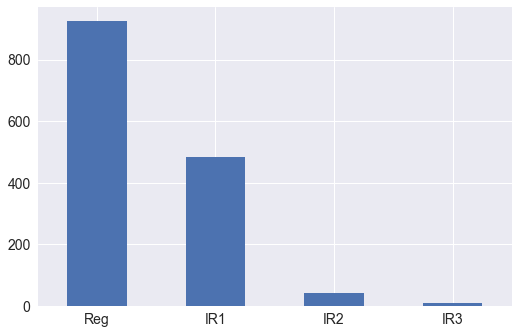

In [82]:
train.LotShape.value_counts().plot(kind='bar',rot=0, figsize=(8.5,5.5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

TotalBsmtSF: Total square feet of basement area
1stFlrSF: First Floor square feet
2ndFlrSF: Second floor square feet

-create dummies for MSZoning (6 zones), Street (gravel or paved)


In [41]:
numeric_feats = [all_data.dtypes[all_data.dtypes != "object"]]
#similar to: numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats[:]

[1stFlrSF           int64
 2ndFlrSF           int64
 3SsnPorch          int64
 BedroomAbvGr       int64
 BsmtFinSF1       float64
 BsmtFinSF2       float64
 BsmtFullBath     float64
 BsmtHalfBath     float64
 BsmtUnfSF        float64
 EnclosedPorch      int64
 Fireplaces         int64
 FullBath           int64
 GarageArea       float64
 GarageCars       float64
 GarageYrBlt      float64
 GrLivArea          int64
 HalfBath           int64
 Id                 int64
 KitchenAbvGr       int64
 LotArea            int64
 LotFrontage      float64
 LowQualFinSF       int64
 MSSubClass         int64
 MasVnrArea       float64
 MiscVal            int64
 MoSold             int64
 OpenPorchSF        int64
 OverallCond        int64
 OverallQual        int64
 PoolArea           int64
 SalePrice        float64
 ScreenPorch        int64
 TotRmsAbvGrd       int64
 TotalBsmtSF      float64
 WoodDeckSF         int64
 YearBuilt          int64
 YearRemodAdd       int64
 YrSold             int64
 dtype: obje

### Linear Regression

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train, train.SalePrice, test_size=0.33, random_state=42)

In [38]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
price_predict = regr.predict(X_test)

ValueError: could not convert string to float: 'Normal'

482